In [2]:
#Jack Gao (C) 2020
#program that predicts the price of the stock TSLA
#-----------------------------------------------------------------------------------------------------------------------
import tensorflowjs as tfjs
import pandas as pd
import time
import math
from collections import deque
from sklearn import preprocessing
import numpy as np
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
import random
import sklearn
import scipy.sparse as sparse
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt

#important variables
num_rows = 2584
price_to_predict = "TSLA_CLOSE"
back_check = 60
bSize = 69
e = 20
plt.style.use('fivethirtyeight')
#Get the past stock prices for training
#-----------------------------------------------------------------------------------------------------------------------
TSLA = web.DataReader("TSLA", data_source = "yahoo", start = "2010-06-29", end = "2020-10-1")
#list of competitor stocks: ford motor company, general motors, honda motor company, toyota motor corp
F = web.DataReader("F", data_source = "yahoo", start = "2010-06-29", end = "2020-10-1")
HMC = web.DataReader("HMC", data_source = "yahoo", start = "2010-06-29", end = "2020-10-1")
TM = web.DataReader("TM", data_source = "yahoo", start = "2010-06-29", end = "2020-10-1")

#2010-06-29 is the first day that TSLA had a stock price hyin 2010

C:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


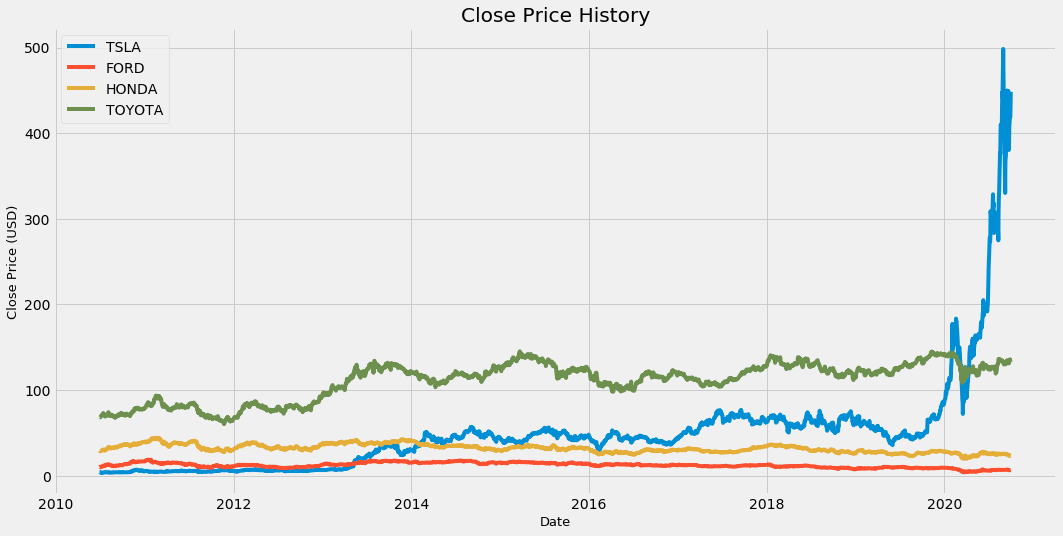

In [3]:
#plotting the price history
#-----------------------------------------------------------------------------------------------------------------------
#GRAPH PLTING CODE
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(TSLA['Close'])
plt.plot(F['Close'])
plt.plot(HMC['Close'])
plt.plot(TM['Close'])
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Close Price (USD)', fontsize = 13)
plt.legend(['TSLA', 'FORD', 'HONDA', 'TOYOTA'], loc = "upper left")
plt.show()

In [4]:
#only take the close values as well as the dates
#shape is all the same (2584), so that means we can join them easily
TSLA = TSLA['Close']
F = F['Close']
HMC = HMC['Close']
TM = TM['Close']
dates = np.array(TSLA.index.values)
TSLA_data = np.array(TSLA)
F_data = np.array(F)
HMC_data = np.array(HMC)
TM_data = np.array(TM)

In [5]:
#putting the data together into a pandas Dataframe
#creating targets
target = []
for i in range(0, 2584):
    if(i == 0):
        target.append(0)
    else:
#         if TSLA[i] > TSLA[i - 1]:
#             target.append(1)
#         else:
#             target.append(0)
        target.append(100.0*(TSLA[i] - TSLA[i - 1])/TSLA[i - 1])
target = np.array(target)

df = pd.DataFrame(columns=['TSLA_CLOSE', 'FORD_CLOSE', 'HONDA_CLOSE', 'TOYOTA_CLOSE', 'Target'])
for i in range(2584):
    df.loc[i] = [#dates[i],
                 TSLA[i],
                 F[i],
                 HMC[i],
                 TM[i],
                 target[i]]
#done sorting data into dataframe
#normalizing and splitting into training and test
def split_train_test(rows, backCheck, ratio):
    rows -= 2*backCheck
    #return training number then test number
    train = (int)((1-ratio)*rows)
    return (train, rows - train)

(num_train, num_test) = split_train_test(num_rows, back_check, 0.3)

#separate test and training data
train_df = df[(df.index < num_train + back_check)]
test_df = df[(df.index >= num_train + back_check)]
#scale the data
#preprocess the training data
def preprocess_data(data):
    for col in data.columns:
        if col != "Target" and col != "Date":
            data[col] = data[col].pct_change() #normalizes the data
            data.dropna(inplace=True) #removes NaN values sets to 0
            data[col] = preprocessing.scale(data[col].values) #scaling the data
    data.dropna(inplace = True) #jsut in case it produces another NaN
    sequential_data = []
    prev_days = deque(maxlen=back_check) #sliding window of previous 60 values
    for i in data.values:
        #add the previous days to the data
        prev_days.append([n for n in i[:-1]])#takes all previous days
        if len(prev_days) == back_check:
            sequential_data.append([np.array(prev_days), i[-1]])
    random.shuffle(sequential_data)
    X = []
    Y = []
    for seq, t in sequential_data:
        X.append(seq)
        Y.append(t)
    return np.array(X), np.array(Y)
train_x, train_y = preprocess_data(train_df)
test_x, test_y = preprocess_data(test_df)

C:\Users\Jack Gao\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Jack Gao\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Jack Gao\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

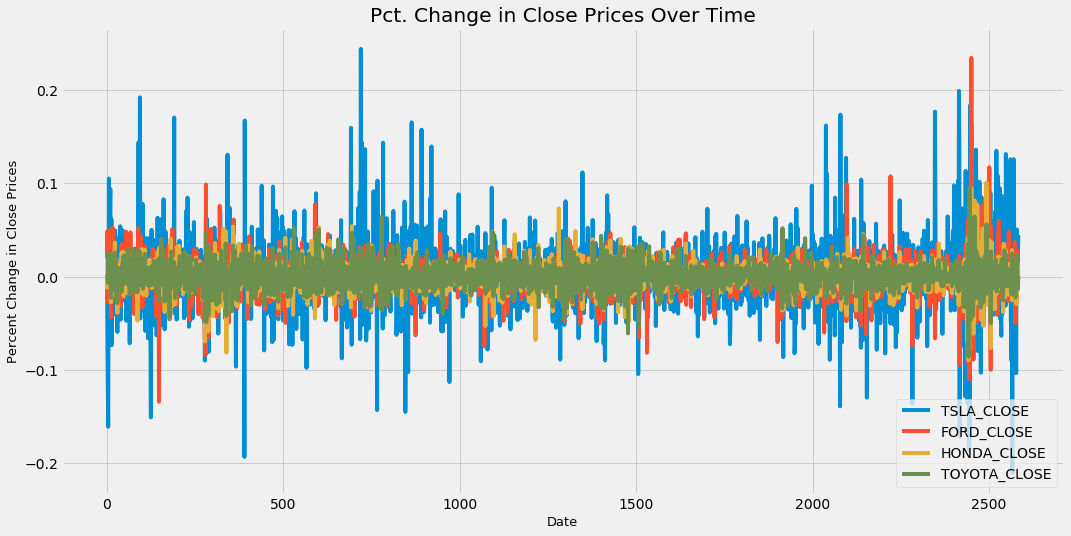

In [6]:
#plot the percent change data
plt.figure(figsize = (16, 8))
plt.title("Pct. Change in Close Prices Over Time")
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Percent Change in Close Prices', fontsize = 13)
col_names = []
for col in df.columns:
    if col != 'Target' and col != 'Close':
        x = df[col].pct_change()
        plt.plot(x)
        col_names.append(col)
plt.legend(col_names, loc = "lower right")
plt.show()

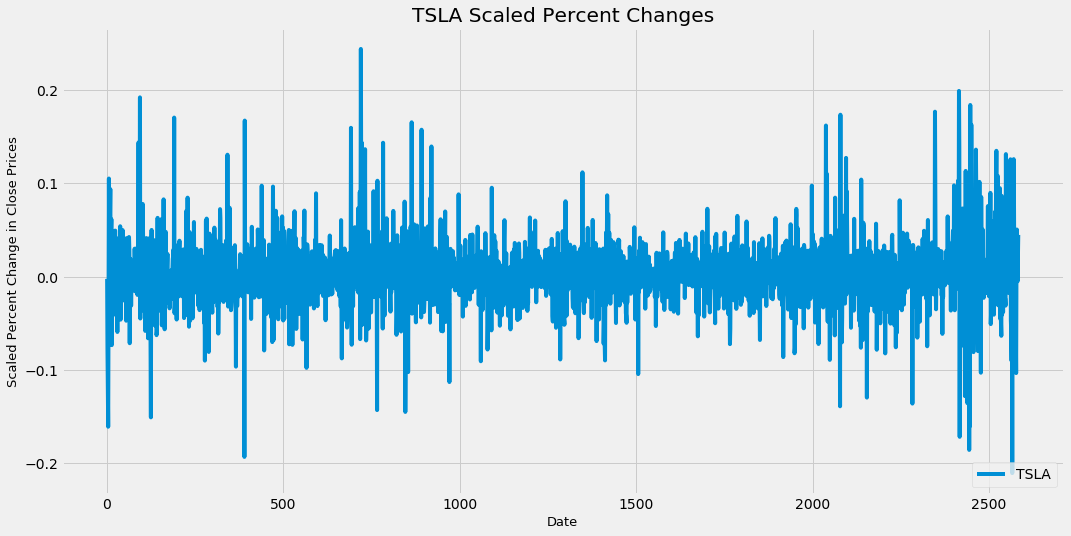

In [7]:
#plot percent change in TSLA close price
plt.figure(figsize = (16, 8))
plt.title("TSLA Scaled Percent Changes")
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Scaled Percent Change in Close Prices', fontsize = 13)
x = df['TSLA_CLOSE'].pct_change()
x.dropna(inplace=True)
plt.plot(x)
plt.legend(['TSLA'], loc = "lower right")
plt.show()

In [8]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1721, 60, 4)
(1721,)
(737, 60, 4)
(737,)


In [18]:
#model
# #setting a checkpoint to save the "best" (lowest validationa accuracy) version of the model network
checkpoint = ModelCheckpoint('model-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', 
                            verbose=1, 
                            monitor='val_loss',
                            save_best_only=True,
                            mode='auto')  
model = Sequential()

model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(128, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(1))

# inputs = keras.layers.Input(shape=(train_x.shape[1], train_x.shape[2]))
# lstm_out = keras.layers.LSTM(32)(inputs)
# outputs = keras.layers.Dense(1)(lstm_out)
# model = keras.Model(inputs=inputs, outputs=outputs)

#opt = keras.optimizers.Adam(lr = 0.001, decay = 1e-6)

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
#model.summary()

numEpochs = 32

model.fit(train_x, 
          train_y, 
          batch_size = bSize, 
          epochs = 32,
          validation_data = (test_x, test_y), 
           callbacks=[checkpoint])

Epoch 1/32
25/25 [==============================] - 12s 266ms/step - loss: 9.8740 - val_loss: 17.9643

Epoch 00001: val_loss improved from inf to 17.96425, saving model to model-001-10.227200-17.964254.h5
Epoch 2/32
25/25 [==============================] - 5s 219ms/step - loss: 9.0750 - val_loss: 17.9199

Epoch 00002: val_loss improved from 17.96425 to 17.91992, saving model to model-002-10.176467-17.919918.h5
Epoch 3/32
25/25 [==============================] - 5s 218ms/step - loss: 10.5673 - val_loss: 17.9959

Epoch 00003: val_loss did not improve from 17.91992
Epoch 4/32
25/25 [==============================] - 5s 216ms/step - loss: 9.1251 - val_loss: 17.5738

Epoch 00004: val_loss improved from 17.91992 to 17.57384, saving model to model-004-10.077879-17.573845.h5
Epoch 5/32
25/25 [==============================] - 5s 217ms/step - loss: 8.9190 - val_loss: 12.3828

Epoch 00005: val_loss improved from 17.57384 to 12.38281, saving model to model-005-9.281093-12.382812.h5
Epoch 6/32
25/

In [19]:
#kernel added to convert keras model to tensorflowjs model
tfjs.converters.save_keras_model(model, "C:\\Users\\Jack Gao\\Downloads\\NN Models")

C:\Users\Jack Gao\AppData\Roaming\Python\Python37\site-packages\tensorflowjs\converters\keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [9]:
test_predictions = model.predict(test_x)
train_predictions = model.predict(train_x)

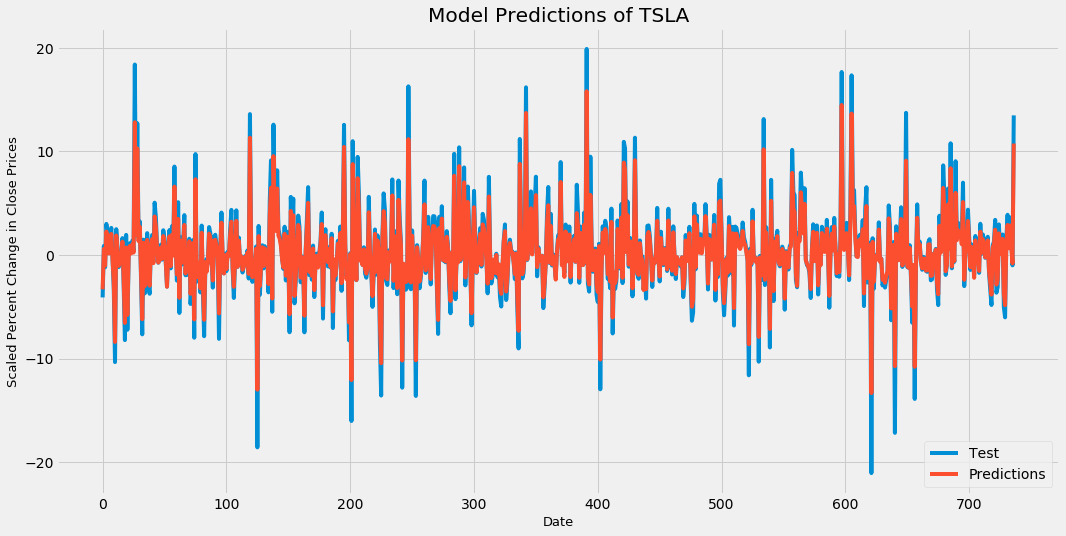

In [10]:
plt.figure(figsize = (16, 8))
plt.title("Model Predictions of TSLA")
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Scaled Percent Change in Close Prices', fontsize = 13)
plt.plot(test_y)
plt.plot(test_predictions)
plt.legend(['Test', 'Predictions'], loc = "lower right")
plt.show()

In [20]:
rmse = np.sqrt(np.mean((test_y - test_predictions)**2))
print(rmse)

0.16999070355353335


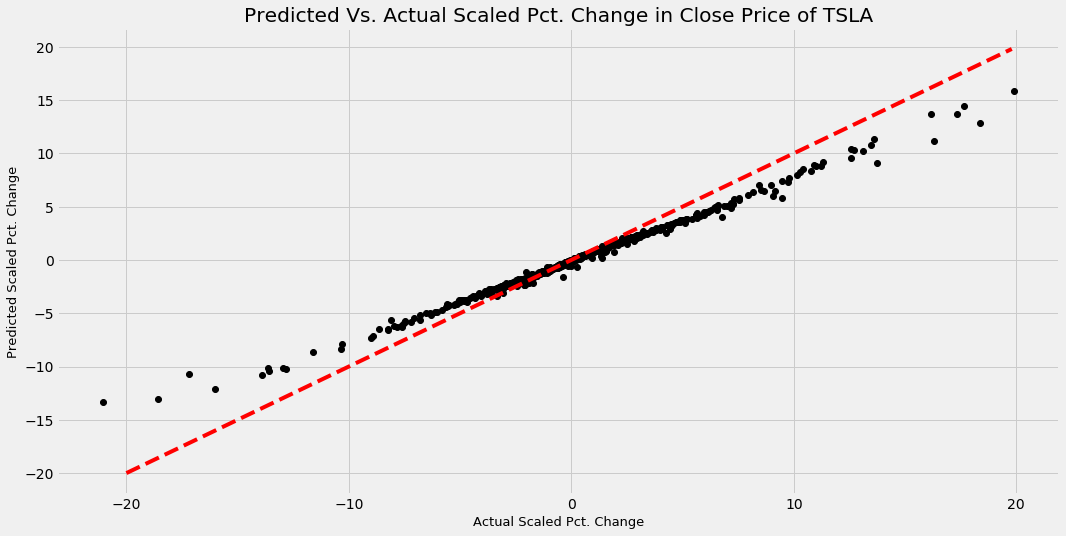

In [18]:
#combine the data (actual vs predicted)
test_predictions = np.array(test_predictions)
grouped_data = []
for i in range(0, len(test_y)):
    grouped_data.append([test_y[i], test_predictions[i]])
plt.figure(figsize = (16, 8))
plt.title("Predicted Vs. Actual Scaled Pct. Change in Close Price of TSLA")
plt.xlabel('Actual Scaled Pct. Change', fontsize = 13)
plt.ylabel('Predicted Scaled Pct. Change', fontsize = 13)
for i in range(0, len(test_y)):
    #plot the scatter points
    plt.plot(grouped_data[i][0], grouped_data[i][1], 'o', color = 'black')
#plot the line of best fit
#plt.plot(np.unique(grouped_data[:0]), np.poly1d(np.polyfit(grouped_data[:0], grouped_data[:1], 1))(np.unique(grouped_data[:0])))
#plot the line representing 100% accuracy
t = np.arange(-20., 20, 0.2)
plt.plot(t, t, 'r--')
plt.show()

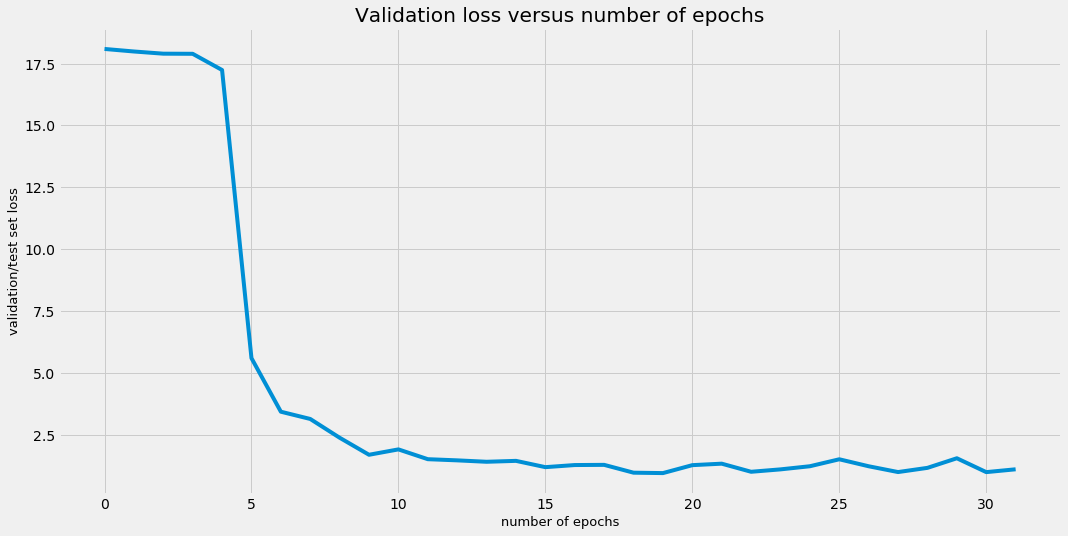

In [14]:
val_loss = [18.0925, 17.9899, 17.9011, 17.8963, 17.2408, 5.5939,3.4267, 3.1330, 2.3746, 1.6856, 1.9032, 1.5069, 1.4598, 1.4024, 1.4394, 1.1850, 1.2701, 1.2778, 0.9612, 0.9449, 1.2658, 1.3257, 0.9981, 1.0954, 1.2219, 1.5032, 1.2209, 0.9868, 1.1565, 1.5444, 0.9842, 1.0986]
plt.figure(figsize = (16,8))
plt.title("Validation loss versus number of epochs")
plt.xlabel("number of epochs", fontsize = 13)
plt.ylabel("validation/test set loss", fontsize = 13)
plt.plot(val_loss)
plt.show()
